**NLP - Extracting product info from texts with LLM**

- *Karina Tiurina*
- *Salveen Dutt*
- *Patryk Prusak*

Comparison of various NLP models in the task of classifying reviews to specific product types extracting product keywords and attributes.


Metrics used:

1. Smith-Waterman
2. Needleman-Wunsch
3. Levenshtein Distance
5. Bert Score
6. Hamming Distance

Models used:

1. "Qwen/Qwen2.5-7B-Instruct"
2. "google/gemma-2-2b-it"
3. "google/gemma-2-9b-it"
4. "meta-llama/Llama-3.1-8B-Instruct"
5. "meta-llama/Llama-3.2-3B-Instruct"
6. "arcee-ai/Arcee-Spark"
7. "mistralai/Ministral-8B-Instruct-2410"

#### Inputs & Consts

In [1]:
import json
import bert_score
from transformers import pipeline
import torch
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import Levenshtein
from Bio import pairwise2
import logging

sns.set_theme(palette="cubehelix")

c:\Users\prusak.patryk\Documents\Repos\nlp-labs\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\prusak.patryk\Documents\Repos\nlp-labs\.venv\Lib\site-packages\Bio\pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


#### Define data

In [2]:
with open("products.json", "r") as file:
    products = json.load(file)

In [3]:
products["products"]["Electric Bike"]["reviews"][0]["review_content"]

'The main thing: on the battery itself, driving calmly, not exceeding 30 km/h, you can do 60-70km.'

#### Comparison metrics

In [3]:
def extract_information(product):
    product_category = product["product_category"]
    if "type" in product_category:
        product_category = product_category["type"]
    product_attributes = product["product_attributes"]
    other_keywords = product["other_keywords"]
    return product_category, product_attributes, other_keywords


def extract_and_concat_data(product):
    product_category, product_attributes, other_keywords = extract_information(product)
    return (
        product_category
        + " "
        + " ".join(product_attributes)
        + " "
        + " ".join(other_keywords)
    )

In [4]:
def hamming_distance(llm_response, original_data):
    original_data_whole = extract_and_concat_data(original_data)
    llm_response_whole = extract_and_concat_data(llm_response)

    # calculate hamming distance
    hamming_distance = 0
    for ch1, ch2 in zip(original_data_whole, llm_response_whole):
        if ch1 != ch2:
            hamming_distance += 1
    hamming_distance += abs(len(original_data_whole) - len(llm_response_whole))
    return hamming_distance


def levenshtein_distance(llm_response, original_data):
    original_data_whole = extract_and_concat_data(original_data)
    llm_response_whole = extract_and_concat_data(llm_response)

    return Levenshtein.distance(original_data_whole, llm_response_whole)


def bert_metric(llm_response, original_data):
    original_data_whole = extract_and_concat_data(original_data)
    llm_response_whole = extract_and_concat_data(llm_response)

    # Suppress the warning
    logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)

    P, R, F1 = bert_score.score(
        [llm_response_whole], [original_data_whole], lang="en", verbose=False
    )
    return F1.item()


def jaccard_distance(llm_response, original_data):
    original_data_whole = extract_and_concat_data(original_data)
    llm_response_whole = extract_and_concat_data(llm_response)

    return 1 - len(
        set(original_data_whole).intersection(set(llm_response_whole))
    ) / len(set(original_data_whole).union(set(llm_response_whole)))


def needleman_wunsch_distance(llm_response, original_data):
    original_data_whole = extract_and_concat_data(original_data)
    llm_response_whole = extract_and_concat_data(llm_response)

    return pairwise2.align.globalxx(
        original_data_whole,
        llm_response_whole,
        one_alignment_only=True,
        score_only=True,
    )


def smith_waterman_distance(llm_response, original_data):
    original_data_whole = extract_and_concat_data(original_data)
    llm_response_whole = extract_and_concat_data(llm_response)

    return pairwise2.align.localxx(
        original_data_whole,
        llm_response_whole,
        one_alignment_only=True,
        score_only=True,
    )

#### Execution

In [5]:
# define prompt template
prompt_template = """
You are an assistant, helping in understanding of reviews. Carefully read the review:
{content}

Return json format with the following JSON schema:

{{
        "product_category": {{
            "type": "string",
            "enum": ["Electric bicycle", "Refrigirator", "The Blocks", "Others"]
        }},
        "product_attributes": {{
            "type": "array",
            "items": {{
                "type": "string"
            }}
        }},
        "other_keywords": {{
            "type": "array",
            "items": {{
                "type": "string"
            }}
        }},

}}
"""

In [6]:
similarity_metrics = [
    hamming_distance,
    levenshtein_distance,
    bert_metric,
    jaccard_distance,
    needleman_wunsch_distance,
    smith_waterman_distance,
]

In [ ]:
# Inspiration for model selection taken from https://huggingface.co/collections/open-llm-leaderboard/open-llm-leaderboard-best-models-652d6c7965a4619fb5c27a03

models = [
    "Qwen/Qwen2.5-7B-Instruct",
    "google/gemma-2-2b-it",
    "google/gemma-2-9b-it",
    "meta-llama/Llama-3.1-8B-Instruct",
    "meta-llama/Llama-3.2-3B-Instruct",
    "arcee-ai/Arcee-Spark",
    "mistralai/Ministral-8B-Instruct-2410",
]

In [8]:
responses = []
nlp = None

In [ ]:
for model in models:
    try:

        # load in 4bit greatly reduces the memory usage
        nlp = pipeline(
            "text-generation",
            model=model,
            model_kwargs={
                "torch_dtype": torch.bfloat16,
                "quantization_config": {
                    "load_in_4bit": True,
                },
                "low_cpu_mem_usage": True,
            },
        )

    except Exception as e:
        print(f"Failed to load model {model}, error: {e}")
        continue
    for productType in products["products"].keys():
        print(f"Generating responses for {productType} reviews using {model}...")
        for review in products["products"][productType]["reviews"]:
            try:
                reviews_content = review["review_content"]

                prompt = prompt_template.format(content=reviews_content)
                messages = [
                    {"role": "user", "content": prompt},
                ]
                outputs = nlp(messages, max_new_tokens=256)
                responses.append(
                    [outputs[0]["generated_text"][1]["content"], review, model]
                )

            except Exception as e:
                print(
                    f"Failed to generate response for {productType} review, error: {e}"
                )
                continue
    try:
        # the memory is probably freed up, but to be safe we delete the nlp object and empty the cache
        del nlp
        torch.cuda.empty_cache()
    except Exception as e:
        print(f"Failed to delete nlp object, error: {e}")
        continue

Loading checkpoint shards: 100%|██████████| 4/4 [00:24<00:00,  6.14s/it]


Generating responses for Electric Bike reviews using Qwen/Qwen2.5-7B-Instruct...
Generating responses for Refrigirator reviews using Qwen/Qwen2.5-7B-Instruct...
Generating responses for The LEGO reviews using Qwen/Qwen2.5-7B-Instruct...
Generating responses for Electric Bike reviews using Qwen/Qwen2.5-1.5B...
Generating responses for Refrigirator reviews using Qwen/Qwen2.5-1.5B...
Generating responses for The LEGO reviews using Qwen/Qwen2.5-1.5B...


Loading checkpoint shards: 100%|██████████| 2/2 [00:10<00:00,  5.29s/it]


Generating responses for Electric Bike reviews using google/gemma-2-2b-it...
Generating responses for Refrigirator reviews using google/gemma-2-2b-it...
Generating responses for The LEGO reviews using google/gemma-2-2b-it...


Loading checkpoint shards: 100%|██████████| 2/2 [00:13<00:00,  6.62s/it]
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Generating responses for Electric Bike reviews using meta-llama/Llama-3.2-3B-Instruct...


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Generating responses for Refrigirator reviews using meta-llama/Llama-3.2-3B-Instruct...


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Generating responses for The LEGO reviews using meta-llama/Llama-3.2-3B-Instruct...


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


In [11]:
with open("responses.pkl", "wb") as f:
    pickle.dump(responses, f)

#### Results

In [52]:
with open("responses.pkl", "rb") as f:
    responses = pickle.load(f)

In [44]:
scoreArr = []

In [ ]:
for i, response in enumerate(responses):
    scoreArr.append([None for j in range(len(similarity_metrics))])
    try:
        llm_response = response[0]
        if not isinstance(llm_response, dict):
            llm_response = json.loads(
                llm_response.replace("```json\n", "").replace("\n```", "")
            )

        for metricIndex, metric in enumerate(similarity_metrics):
            scoreArr[-1][metricIndex] = metric(
                llm_response, response[1]["golden_answer"]
            )
    except Exception as e:
        print(f"Failed to calculate scores for response {i}, error: {e}")
        continue

Calculating scores for response 0...
Calculating scores for response 1...
Calculating scores for response 2...
Calculating scores for response 3...
Calculating scores for response 4...
Calculating scores for response 5...
Calculating scores for response 6...
Calculating scores for response 7...
Calculating scores for response 8...
Calculating scores for response 9...
Failed to calculate scores for response 9, error: Expecting value: line 1 column 1 (char 0)
Calculating scores for response 10...
Failed to calculate scores for response 10, error: Expecting value: line 1 column 1 (char 0)
Calculating scores for response 11...
Failed to calculate scores for response 11, error: Expecting value: line 1 column 1 (char 0)
Calculating scores for response 12...
Failed to calculate scores for response 12, error: Expecting value: line 1 column 1 (char 0)
Calculating scores for response 13...
Failed to calculate scores for response 13, error: Expecting value: line 1 column 1 (char 0)
Calculating sc

In [53]:
for i, score in enumerate(scoreArr):
    responses[i] = responses[i] + score

In [ ]:
columns = ["response", "review", "model"] + [
    metric.__name__ for metric in similarity_metrics
]
results_df = pd.DataFrame(responses, columns=columns)
results_df.to_csv("results.csv", index=False)

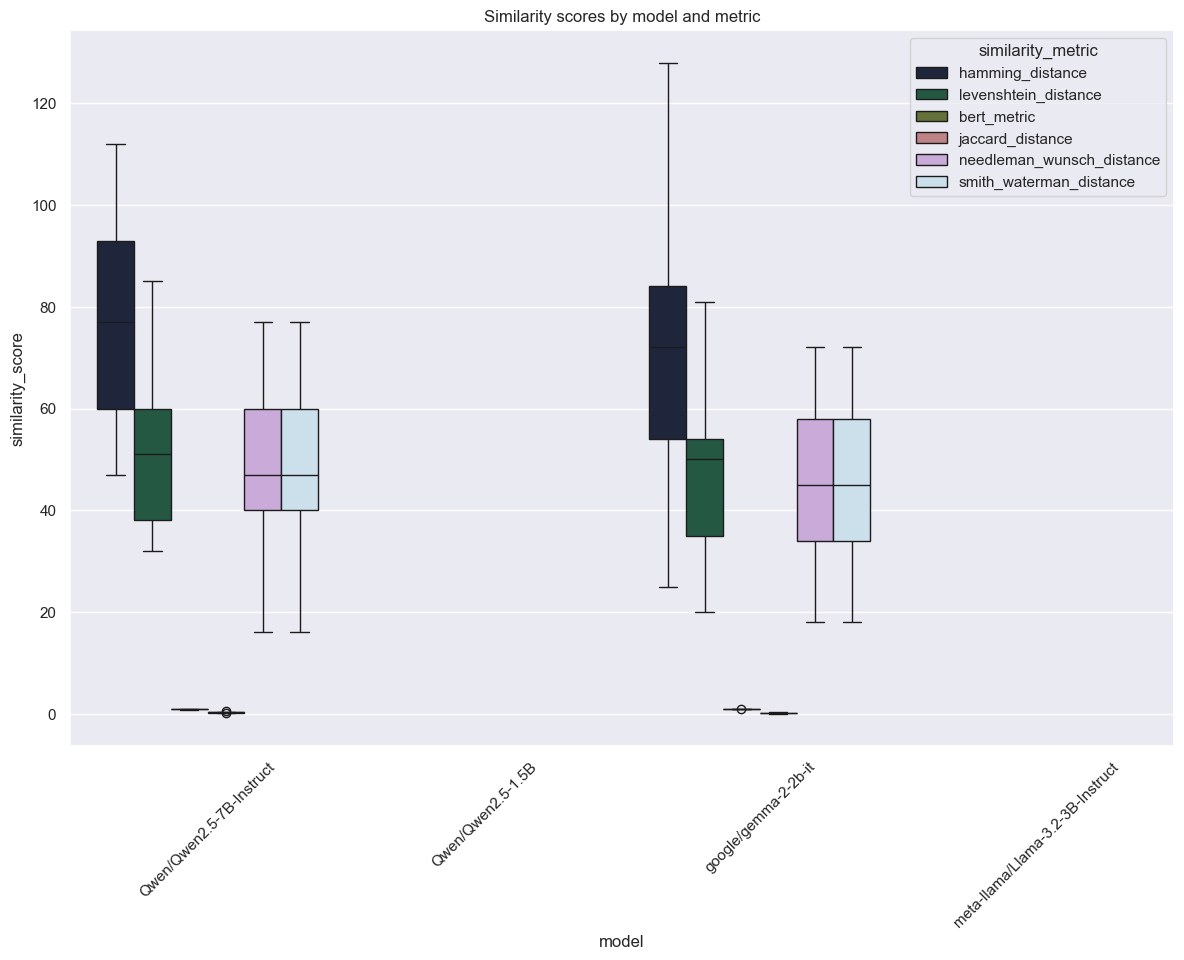

In [58]:
results_transformed = results_df.melt(
    id_vars=["response", "review", "model"],
    var_name="similarity_metric",
    value_name="similarity_score",
)

results_transformed.to_csv("results_transformed.csv", index=False)
plt.figure(figsize=(12, 8))
sns.boxplot(
    data=results_transformed, x="model", y="similarity_score", hue="similarity_metric"
)
plt.tight_layout()
plt.title("Similarity scores by model and metric")
plt.xticks(rotation=45)
plt.show()

In [59]:
results_df.head(5)

,response,review,model,hamming_distance,levenshtein_distance,bert_metric,jaccard_distance,needleman_wunsch_distance,smith_waterman_distance
0,"```json\n{\n ""product_category"": ""Electric ...",{'review_content': 'The main thing: on the bat...,Qwen/Qwen2.5-7B-Instruct,71.0,51.0,0.885455,0.333333,43.0,43.0
1,"```json\n{\n ""product_category"": ""Elect...","{'review_content': 'Super contact, the bike lo...",Qwen/Qwen2.5-7B-Instruct,112.0,85.0,0.851733,0.259259,77.0,77.0
2,"```json\n{\n ""product_category"": {\n ...",{'review_content': 'The bike is great. We'll s...,Qwen/Qwen2.5-7B-Instruct,47.0,38.0,0.806645,0.523810,16.0,16.0
3,"```json\n{\n ""product_category"": {\n ...",{'review_content': 'Super refrigerator and act...,Qwen/Qwen2.5-7B-Instruct,77.0,43.0,0.835683,0.160000,60.0,60.0
4,"```json\n{\n ""product_category"": {\n ...",{'review_content': 'Very capauous refrigerator...,Qwen/Qwen2.5-7B-Instruct,93.0,72.0,0.826518,0.250000,47.0,47.0


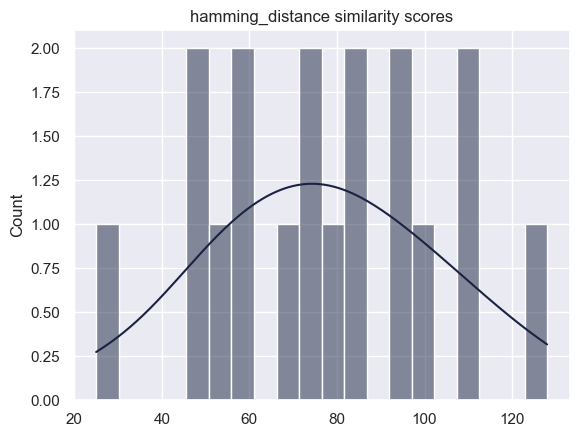

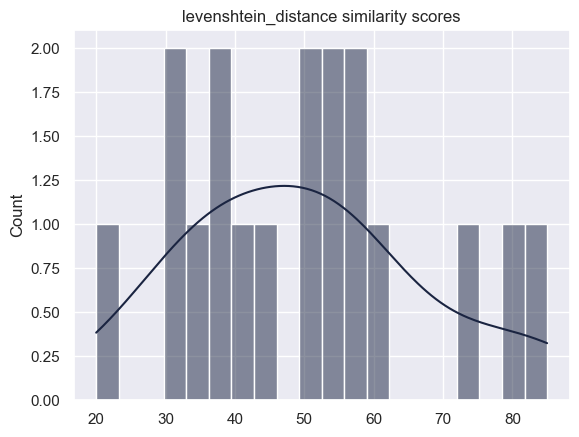

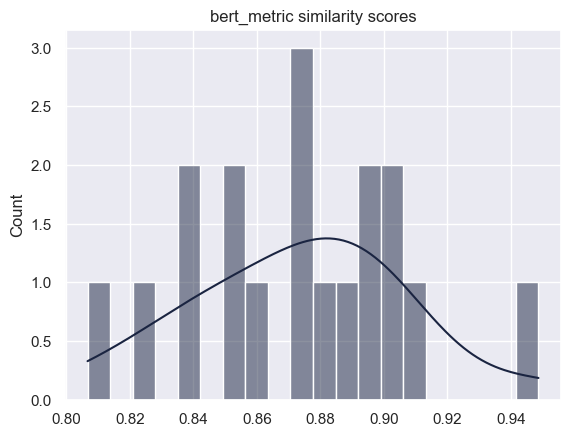

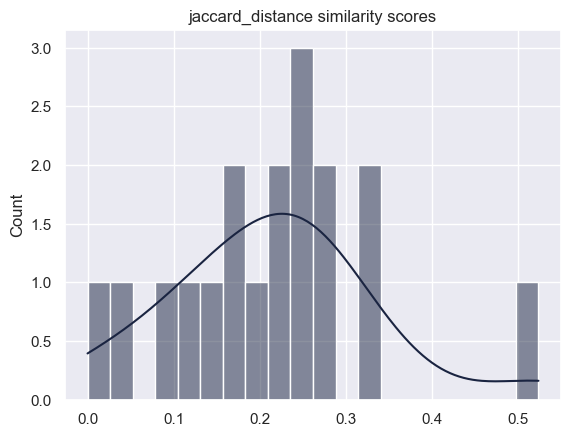

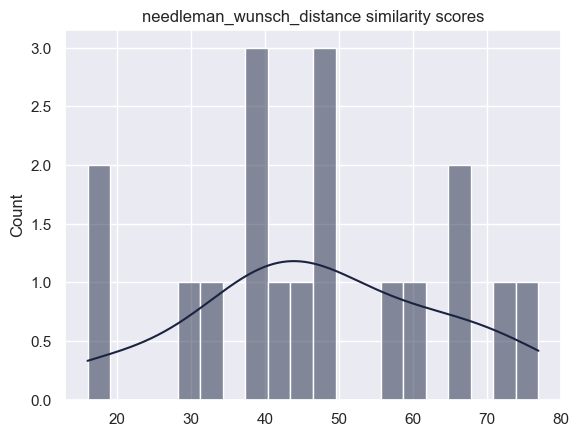

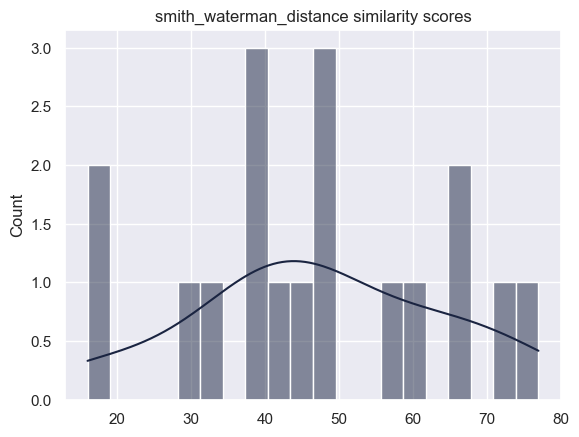

In [47]:
for i, metric in enumerate(similarity_metrics):
    try:
        scores = [score[i] for score in scoreArr]
        sns.histplot(scores, kde=True, bins=20)
        plt.title(f"{metric.__name__} similarity scores")
        plt.show()
    except:
        continue

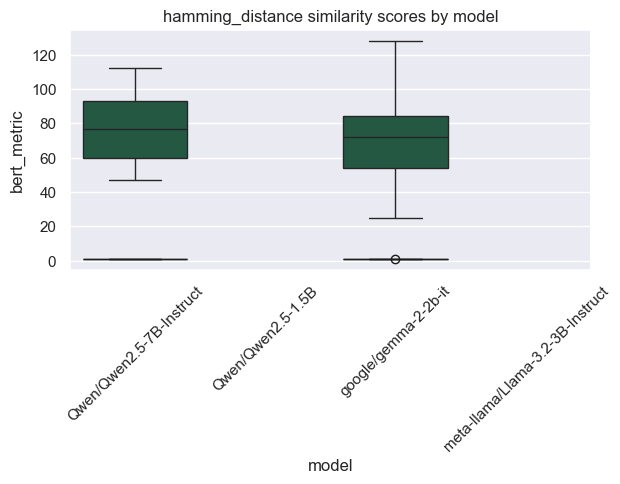

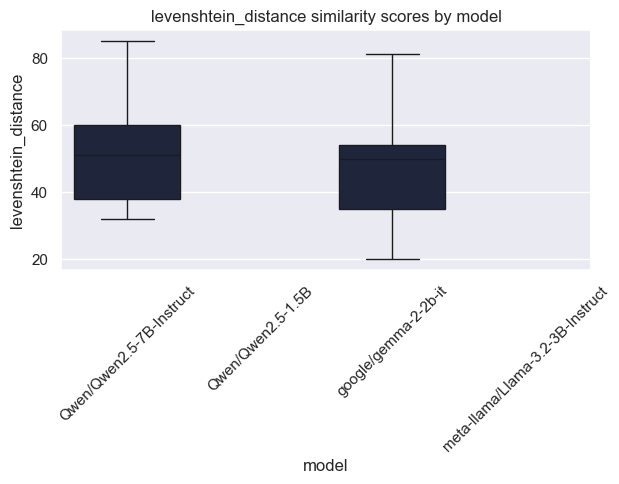

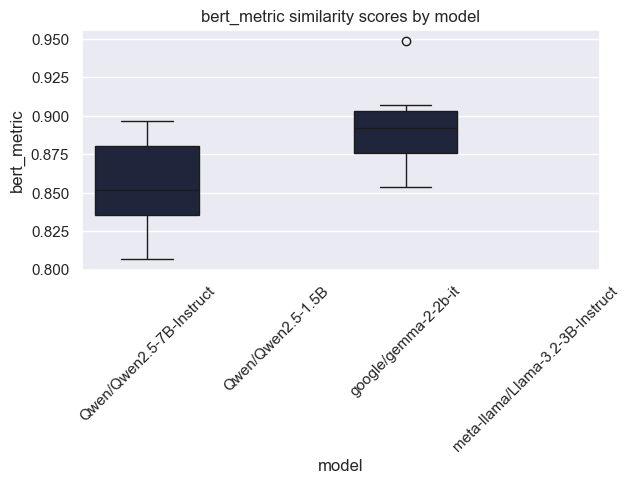

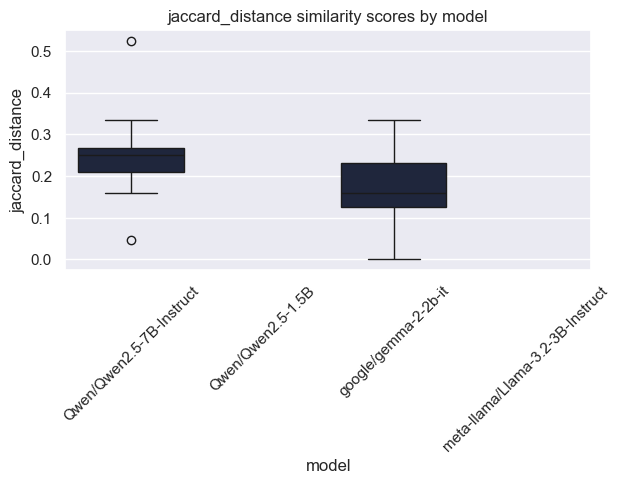

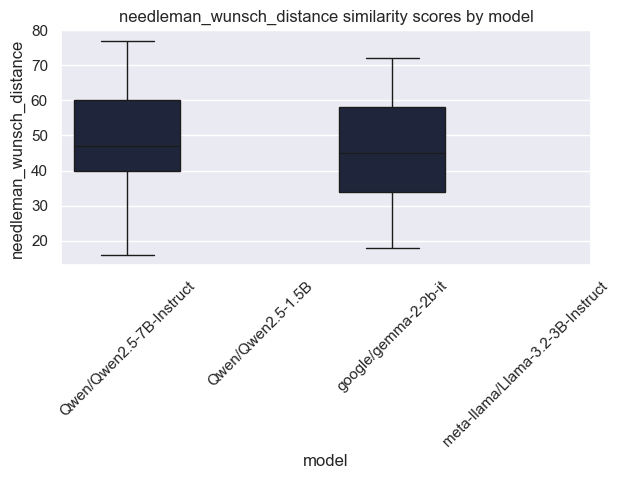

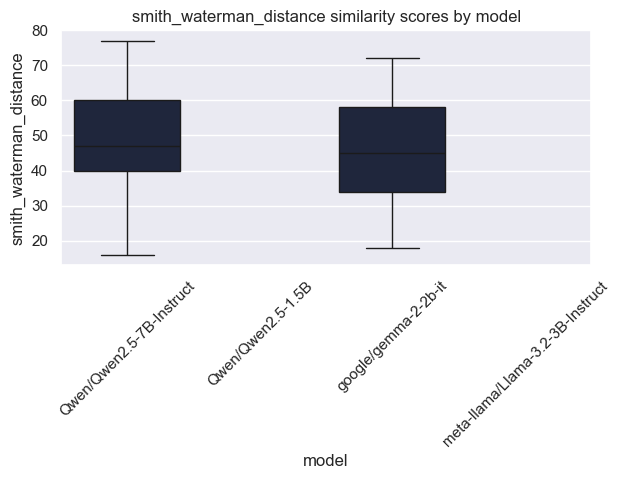

In [ ]:
for metric in similarity_metrics:
    sns.boxplot(data=results_df, x="model", y=metric.__name__)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.title(f"{metric.__name__} similarity scores by model")
    plt.show()